<a href="https://colab.research.google.com/github/Sinudeshmukh/Data-Science-Project/blob/main/Fraud_Analytics_Optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [31]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

### Dataset loading

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
df = pd.read_csv("/content/drive/MyDrive/Project Fraud Analytics/Insurance Dataset.csv")
df.head()

,Area_Service,Hospital County,Hospital Id,Age,Gender,Cultural_group,ethnicity,Days_spend_hsptl,Admission_type,"Home or self care,",ccs_diagnosis_code,ccs_procedure_code,apr_drg_description,Code_illness,Mortality risk,Surg_Description,Weight_baby,Abortion,Emergency dept_yes/No,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
0,Western NY,Allegany,37.0,30 to 49,F,White,Not Span/Hispanic,4,Elective,Home or Self Care,122,0,Other pneumonia,1,1.0,Medical,0,N,Y,5511.95,5582.49,1.012798,1,1
1,Western NY,Allegany,37.0,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Short-term Hospital,197,0,Cellulitis & other skin infections,3,2.0,Medical,0,N,Y,4783.20,5162.82,1.079365,1,1
2,Western NY,Allegany,37.0,30 to 49,F,White,Not Span/Hispanic,3,Urgent,Home or Self Care,122,0,Other pneumonia,1,1.0,Medical,0,N,Y,3829.15,4056.52,1.059379,1,1
3,Western NY,Allegany,37.0,0 to 17,F,White,Not Span/Hispanic,1,Urgent,Home or Self Care,122,0,Other pneumonia,1,1.0,Medical,0,N,Y,1108.20,1644.75,1.484167,0,1
4,Western NY,Allegany,37.0,70 or Older,F,White,Not Span/Hispanic,3,Elective,Home or Self Care,122,0,Other pneumonia,2,3.0,Medical,0,N,Y,3418.18,3370.87,0.986161,1,1


In [34]:
df.columns

Index(['Area_Service', 'Hospital County', 'Hospital Id', 'Age', 'Gender',
       'Cultural_group', 'ethnicity', 'Days_spend_hsptl', 'Admission_type',
       'Home or self care,', 'ccs_diagnosis_code', 'ccs_procedure_code',
       'apr_drg_description', 'Code_illness', 'Mortality risk',
       'Surg_Description', 'Weight_baby', 'Abortion', 'Emergency dept_yes/No',
       'Tot_charg', 'Tot_cost', 'ratio_of_total_costs_to_total_charges',
       'Result', 'Payment_Typology'],
      dtype='object')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   Area_Service                           1046119 non-null  object 
 1   Hospital County                        1046119 non-null  object 
 2   Hospital Id                            1046119 non-null  float64
 3   Age                                    1048575 non-null  object 
 4   Gender                                 1048575 non-null  object 
 5   Cultural_group                         1048575 non-null  object 
 6   ethnicity                              1048575 non-null  object 
 7   Days_spend_hsptl                       1048575 non-null  object 
 8   Admission_type                         1048575 non-null  object 
 9   Home or self care,                     1048575 non-null  object 
 10  ccs_diagnosis_code                     104

In [36]:
df.shape

(1048575, 24)

### Data Preprocessing

#### 1. Drop Duplicates 

In [37]:
df.drop_duplicates(inplace=True,ignore_index=True)
df.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,Hospital Id,ccs_diagnosis_code,ccs_procedure_code,Code_illness,Mortality risk,Weight_baby,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
count,1041306.0,1043761.0,1043761.0,1043761.0,1043720.0,1043761.0,1043761.0,1043761.0,1043761.0,1043761.0,1043761.0
mean,652.5,198.6,97.1,2.1,1.8,282.0,27190.1,10501.2,0.5,0.7,1.9
std,669.6,165.5,87.3,0.9,1.0,932.3,54976.5,22345.9,0.8,0.4,0.8
min,1.0,1.0,0.0,0.0,1.0,0.0,0.3,0.1,0.0,0.0,1.0
25%,213.0,108.0,0.0,1.0,1.0,0.0,7473.6,3262.2,0.3,0.0,1.0
50%,630.0,159.0,88.0,2.0,1.0,0.0,14669.2,5955.4,0.4,1.0,2.0
75%,977.0,218.0,172.0,3.0,3.0,0.0,29242.3,11377.4,0.5,1.0,3.0
max,9250.0,670.0,231.0,4.0,4.0,9000.0,6196973.5,2562477.7,157.6,1.0,5.0


#### 2. Drop NA

In [38]:
df.dropna(inplace=True)
df.isnull().any()

Area_Service                             False
Hospital County                          False
Hospital Id                              False
Age                                      False
Gender                                   False
Cultural_group                           False
ethnicity                                False
Days_spend_hsptl                         False
Admission_type                           False
Home or self care,                       False
ccs_diagnosis_code                       False
ccs_procedure_code                       False
apr_drg_description                      False
Code_illness                             False
Mortality risk                           False
Surg_Description                         False
Weight_baby                              False
Abortion                                 False
Emergency dept_yes/No                    False
Tot_charg                                False
Tot_cost                                 False
ratio_of_tota

#### 3. Drop Columns

In [39]:
df.drop(['Area_Service','Hospital County','Hospital Id','Gender','Cultural_group',"ethnicity","apr_drg_description","Weight_baby",'Abortion','Payment_Typology'], axis=1, inplace=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041265 entries, 0 to 1043760
Data columns (total 14 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   Age                                    1041265 non-null  object 
 1   Days_spend_hsptl                       1041265 non-null  object 
 2   Admission_type                         1041265 non-null  object 
 3   Home or self care,                     1041265 non-null  object 
 4   ccs_diagnosis_code                     1041265 non-null  int64  
 5   ccs_procedure_code                     1041265 non-null  int64  
 6   Code_illness                           1041265 non-null  int64  
 7   Mortality risk                         1041265 non-null  float64
 8   Surg_Description                       1041265 non-null  object 
 9   Emergency dept_yes/No                  1041265 non-null  object 
 10  Tot_charg                              104

###4.Rename Column Names

In [41]:
df = df.rename(columns={'Mortality risk':'Mortality_risk',"Home or self care,":"Home_or_self_care",'Emergency dept_yes/No':'Emergency_dept_yes/No'})
df.columns

Index(['Age', 'Days_spend_hsptl', 'Admission_type', 'Home_or_self_care',
       'ccs_diagnosis_code', 'ccs_procedure_code', 'Code_illness',
       'Mortality_risk', 'Surg_Description', 'Emergency_dept_yes/No',
       'Tot_charg', 'Tot_cost', 'ratio_of_total_costs_to_total_charges',
       'Result'],
      dtype='object')

####5. Converting Columns to Right Datatypes

In [42]:
df.replace({'Days_spend_hsptl': '120 +'}, 120, inplace=True)
df['Mortality_risk'] = df['Mortality_risk'].astype(int)

In [43]:
df

,Age,Days_spend_hsptl,Admission_type,Home_or_self_care,ccs_diagnosis_code,ccs_procedure_code,Code_illness,Mortality_risk,Surg_Description,Emergency_dept_yes/No,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result
0,30 to 49,4,Elective,Home or Self Care,122,0,1,1,Medical,Y,5511.95,5582.49,1.012798,1
1,70 or Older,4,Urgent,Short-term Hospital,197,0,3,2,Medical,Y,4783.20,5162.82,1.079365,1
2,30 to 49,3,Urgent,Home or Self Care,122,0,1,1,Medical,Y,3829.15,4056.52,1.059379,1
3,0 to 17,1,Urgent,Home or Self Care,122,0,1,1,Medical,Y,1108.20,1644.75,1.484167,0
4,70 or Older,3,Elective,Home or Self Care,122,0,2,3,Medical,Y,3418.18,3370.87,0.986161,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043756,70 or Older,6,Emergency,Skilled Nursing Home,106,29,2,3,Medical,Y,69650.41,13896.82,0.199522,1
1043757,0 to 17,2,Emergency,Home or Self Care,8,231,2,1,Medical,N,13587.38,3918.35,0.288382,1
1043758,50 to 69,13,Emergency,Medicare Cert Long Term Care Hospital,151,88,4,4,Medical,Y,104629.78,24746.64,0.236516,0
1043759,30 to 49,2,Emergency,Home or Self Care,143,86,1,1,Surgical,Y,27521.41,6766.04,0.245846,1


###6. Label Encoding

In [44]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [45]:
df['Age']  = labelencoder.fit_transform(df['Age'])
df['Admission_type'] = labelencoder.fit_transform(df['Admission_type'])
df['Home_or_self_care'] = labelencoder.fit_transform(df['Home_or_self_care'])
df['Surg_Description'] = labelencoder.fit_transform(df['Surg_Description'])
df['Emergency_dept_yes/No'] = labelencoder.fit_transform(df['Emergency_dept_yes/No'])

In [46]:
df.corr()

,Age,Admission_type,Home_or_self_care,ccs_diagnosis_code,ccs_procedure_code,Code_illness,Mortality_risk,Surg_Description,Emergency_dept_yes/No,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result
Age,1.000000,-0.109385,0.302961,-0.223039,-0.119909,0.413520,0.498528,0.092201,0.342891,0.099697,0.084832,-0.049608,0.001983
Admission_type,-0.109385,1.000000,-0.040385,0.012607,-0.002615,0.019216,0.013942,-0.163797,-0.076151,-0.031345,-0.022222,0.022305,-0.001403
Home_or_self_care,0.302961,-0.040385,1.000000,-0.070088,-0.000530,0.241575,0.243000,0.023579,0.142063,0.107349,0.096862,-0.012959,0.000477
ccs_diagnosis_code,-0.223039,0.012607,-0.070088,1.000000,0.051307,-0.181906,-0.269338,-0.148600,-0.100412,-0.076322,-0.041976,0.030690,0.000317
ccs_procedure_code,-0.119909,-0.002615,-0.000530,0.051307,1.000000,0.013522,-0.035020,0.047185,-0.170406,0.025710,0.034001,0.017527,-0.000441
Code_illness,0.413520,0.019216,0.241575,-0.181906,0.013522,1.000000,0.635410,-0.084941,0.307177,0.290234,0.246470,-0.033883,0.002065
Mortality_risk,0.498528,0.013942,0.243000,-0.269338,-0.035020,0.635410,1.000000,-0.068615,0.294515,0.221497,0.181717,-0.036955,0.002483
Surg_Description,0.092201,-0.163797,0.023579,-0.148600,0.047185,-0.084941,-0.068615,1.000000,-0.277383,0.210457,0.192765,-0.010672,-0.002039
Emergency_dept_yes/No,0.342891,-0.076151,0.142063,-0.100412,-0.170406,0.307177,0.294515,-0.277383,1.000000,0.010675,-0.009997,-0.049358,0.002676
Tot_charg,0.099697,-0.031345,0.107349,-0.076322,0.025710,0.290234,0.221497,0.210457,0.010675,1.000000,0.723527,-0.043142,-0.001055


In [47]:
df['Result'].value_counts()

1    780361
0    260904
Name: Result, dtype: int64

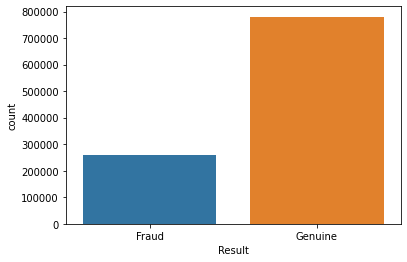

In [48]:
g = sns.countplot(df['Result'])
g.set_xticklabels(['Fraud','Genuine'])
plt.show()

##Assigning X and Y on Variable

In [49]:
X = df.drop(['Result'],axis=1)
Y = df.Result

##Oversampling Complete Dataset using SMOTETomek

In [50]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(ratio="auto",random_state=42)
X_smt, Y_smt = smt.fit_sample(X,Y)

In [51]:
unique, count = np.unique(Y_smt, return_counts=True)
count

array([718461, 718461])

##Train Test Split

In [52]:
X_train,X_test,Y_train,Y_test = train_test_split(X_smt,Y_smt,test_size=0.2,stratify=Y_smt)

In [53]:
unique, count = np.unique(Y_train,return_counts=True)
count

array([574769, 574768])

#**Model Building**

##**Random Forest Classifier**

In [54]:
Model = RandomForestClassifier(n_estimators=13,max_features=6,min_samples_leaf=6,min_samples_split=5,n_jobs=-1)
Model.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [55]:
Y_train_pred = Model.predict(X_train)
print(classification_report(Y_train,Y_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85    574769
           1       0.80      0.99      0.88    574768

    accuracy                           0.87   1149537
   macro avg       0.89      0.87      0.87   1149537
weighted avg       0.89      0.87      0.87   1149537



In [56]:
Y_pred = Model.predict(X_test)
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79    143692
           1       0.75      0.96      0.84    143693

    accuracy                           0.82    287385
   macro avg       0.85      0.82      0.82    287385
weighted avg       0.85      0.82      0.82    287385



#**Model Building on Complete Dataset**

In [57]:
Model_final = RandomForestClassifier(n_estimators=13,max_features=6,min_samples_leaf=6,min_samples_split=5,n_jobs=-1)
Model_final.fit(X_smt,Y_smt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

##Save Model

In [58]:
import joblib
#Serialize the model and save
from sklearn.externals import joblib
joblib.dump(Model_final, 'RFModel.joblib',0)

['RFModel.joblib']

In [59]:
import pickle
with open('Model_final.joblib','wb') as f:
  pickle.dump(Model_final,f,-1)